In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src/')
import wave_mut_rate as wD
import utils as ut
import plotter
import pickle
from copy import deepcopy
from scipy.optimize import brentq

In [2]:
class eps_schedule():
    """
    Scheduling of the diffusion coefficient over the mutation rate
    """
    
    def __init__(self, first_eps, first_time, decay_exp, decay_scale):
        self.first_eps = first_eps
        self.first_time = first_time
        self.decay_exp = decay_exp
        self.decay_scale = decay_scale
        
    def get(self, t):
        if t < self.first_time:
            return self.first_eps
        else:
            t1 = t - self.first_time
            return self.first_eps*( self.decay_scale/(t1 + self.decay_scale) )**self.decay_exp


In [3]:
def build_assay_wave(id_, r0, lambda_tilde, Ds, D_CLF, beta=2, gamma=1,  eps=1e-13, time=3000, Delta_x=1):
    dx = ut.lin_from_two_points(np.log(r0/Delta_x), np.log(0.05), 0.01, np.log(5), 0.035)
    dt = ut.dt_from_cfl(0.03, D_CLF, dx)

    p = wD.Vwave_mut_rate_pars(id_, tot_time=time, dt=dt, dx=dx, 
                     n_x_bins=int( ut.lin_from_two_points(r0/Delta_x, 0.05, 10, 1, 80)/dx ), 
                     M=5, r0=r0, alpha=0, beta=beta, gamma=gamma, lambda_tilde=lambda_tilde,
                     eps=eps, Ds=Ds,
                     Nh=10**10, N0=10**8, cutoff=1,
                     t_burn=ut.lin_from_two_points(r0/Delta_x, 0.05, 250, 5, 5000), 
                     t_burn_cutoff=ut.lin_from_two_points(r0/Delta_x, 0.05, 70, 5, 1000), 
                     #t_burn=200, t_burn_cutoff=100,
                     back_width_fract=ut.lin_from_two_points(np.log(r0/Delta_x), np.log(0.05), 0.5, np.log(5), 3),
                     traj_step=int(25/dt), check_step=int(0/dt), traj_after_burn=True, verbose=True, global_cutoff=True)
    
    return deepcopy(wD.Vwave_mut_rate(p, False))

In [4]:
def D_FKPP_f(p):
    return (p.beta - p.alpha - p.gamma)/(2*p.beta*p.lambda_tilde)
    
    
def vtau_lin(p, meanD):
    return p.r0*((p.beta*(1 - p.lambda_tilde*meanD)/(p.alpha + p.gamma))**(1/p.M) - 1)**(-1)

def sel_coef_lin(p, meanD):
    return (p.alpha + p.gamma)*p.M/vtau_lin(p, meanD)

def speed_lin(p, size, meanD):
    s = sel_coef_lin(p, meanD)
    d_inv = (s/meanD)**(1/3)
    eps0 = - 2.3381
    aux = 3*np.log(size*d_inv)
    return 2*meanD*d_inv*(aux**(1/3) + eps0*aux**(-1/3))

def size_lin(p, meanD):
    vtau = vtau_lin(p, meanD)
    def _Neq(x, p, vtau):
        return (vtau - speed_lin(p, x, meanD)*p.M*p.Nh/x)
    return brentq(_Neq, 1e4, p.Nh*1000, args = (p, vtau))

def D_f_lin(p, D_left, D_right):
    xi0 = - 2.3381
    def f(x):
        Ntot = size_lin(p, x)
        v = speed_lin(p, Ntot, x)
        s = sel_coef_lin(p, x)
        k = xi0 * (x*s**2)**(1/3)
        f = v**2/4/x - k
        return f*(1 - 2*p.lambda_tilde*x) + 2*k*(2/3 - p.lambda_tilde*x) - (p.alpha + p.gamma)*p.lambda_tilde*x
    return brentq(f, D_left, D_right)

def estf(d):
    k = -2.3381 * (d*s**2)**(1/3)
    return f*(1 - 2*l*d) + 2*k*(2/3 - l*d) - (a+g)*l*d

## Finding ES mutation coef for different r0

In [129]:
Delta_x = 0.5
c_list = np.logspace(np.log10(0.05), np.log10(5), 20)
r0_list = c_list * Delta_x
print(c_list)

[0.05       0.06371375 0.08118884 0.1034569  0.13183254 0.16799091
 0.21406662 0.27277974 0.3475964  0.4429334  0.56441895 0.71922494
 0.91649036 1.16786073 1.48817572 1.8963451  2.41646512 3.07924106
 3.92379985 5.        ]


### We set a naive guess of the ED diffusion coefficient and the domain of D in which it is contained

In [130]:
i_change = int(len(c_list)*0.55)
D_guess1 = [ut.lin_from_two_points(np.log(c), np.log(0.05), 5e-4, np.log(0.5), 4.6e-4) for c in c_list[:i_change]]
D_guess2 = [ut.lin_from_two_points(np.log(c), np.log(0.5), 4.6e-4, np.log(5), 2.2e-4) for c in c_list[i_change:]]
D_guess = np.concatenate((D_guess1, D_guess2)) * Delta_x**2
D_window_up = D_guess+1.2e-4 * Delta_x**2
D_window_low = np.max([np.ones(len(r0_list))*1e-6, D_guess-1.2e-4* Delta_x**2], axis=0) 

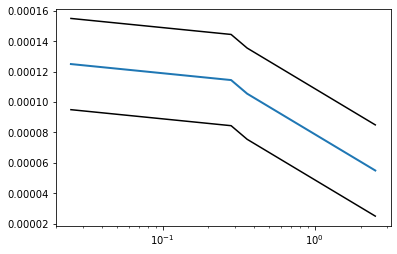

In [131]:
plt.xscale('log')
plt.plot(r0_list, D_guess, lw=2)
plt.plot(r0_list, D_window_low, c='k')
plt.plot(r0_list, D_window_up, c='k')

### Building the ES wave objects

In [132]:
lambd = 250
lambda_tilde = 2*lambd/Delta_x**2
n_D_bins = 200
time = 60000

In [9]:
assays = []
for i, r0 in enumerate(r0_list):
    Ds = np.linspace(D_window_low[i], D_window_up[i], n_D_bins)
    eps = eps_schedule(0.5e-13, 3000, 2, 500)
    D_CLF = D_guess[i]/2
    assays.append(build_assay_wave(i, r0, lambda_tilde, Ds, D_CLF, time=time, eps=eps))

proc. 0 WARNING: dx is not small compared to r0. dx/r0= 0.19999999999999998
proc. 1 WARNING: dx is not small compared to r0. dx/r0= 0.17760357223743597
proc. 2 WARNING: dx is not small compared to r0. dx/r0= 0.15558270595352247
proc. 3 WARNING: dx is not small compared to r0. dx/r0= 0.13481331718121206
proc. 4 WARNING: dx is not small compared to r0. dx/r0= 0.11577685845393185


### Running simulations
No pickle files are included in the repo since they have large dimensions

In [ ]:
waves = ut.multiprocess_sim(assays, 4)

In [13]:
#f = open('data/mut_rate_Dx=%g_assays.pickle'%Delta_x, 'wb')
#pickle.dump(waves, f)
#f.close()

In [133]:
f = open('data/mut_rate_Dx=%g_assays.pickle'%Delta_x, 'rb')
waves = pickle.load(f)
f.close()

### Checking convergence to the stationary state

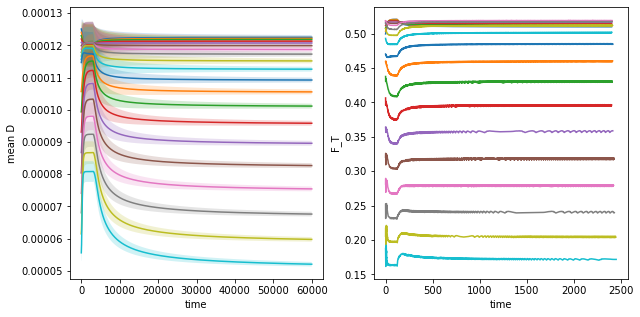

In [134]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.set_xlabel('time')
ax1.set_ylabel('mean D')
ax2.set_xlabel('time')
ax2.set_ylabel('F_T')

mean_D, max_D = [], []
speeds, f_tips, s_tips = np.array([]),np.array([]), np.array([])
r0_lin_start = 2
D_flin = np.array([])
est = np.array([])
for w in waves:
    speeds = np.append(speeds, np.mean(w.traj.speed(5)[-50:]))
    f_tips = np.append(f_tips, np.mean(w.traj.f_tip[-50:]))
    s_tips = np.append(s_tips, np.mean(w.traj.s_tip[-50:]))
    mean_D.append(w.traj.mean_D[-1]),
    max_D.append(w.traj.max_D[-1])
    
    ax1.plot(w.traj.times - w.p.t_burn, w.traj.mean_D)
    std = w.traj.std_D
    ax1.fill_between(w.traj.times - w.p.t_burn, w.traj.mean_D-std, w.traj.mean_D+std, alpha=0.2)
    ax2.plot(w.traj.f_tip)
    
    a, g, l = w.p.alpha, w.p.gamma, w.p.lambda_tilde
    v, f, s = speeds[-1], f_tips[-1], s_tips[-1]
    est = np.append(est, brentq(estf, 1e-5, 1.3e-4))
    
    if w.p.r0 > r0_lin_start:
        D_flin = np.append(D_flin, D_f_lin(w.p, 1e-5, 1.3e-4))

## Looking for ES D at large r0 using "adiabatic" initial conditions (the final n and h profiles of the provious r0)

In [135]:
def build_assay_wave2(id_, r0, lambda_tilde, Ds, D_guess, beta=2, gamma=1,  eps=1e-13, time=3000, init_n=None, init_nh=None, t_burn=10000, t_burn_cutoff=0):
    dx = 0.035
    dt = ut.dt_from_cfl(0.03, D_guess/2, dx)

    p = wD.Vwave_mut_rate_pars(id_, tot_time=time, dt=dt, dx=dx, 
                     n_x_bins=int(500/dx), 
                     M=5, r0=r0, alpha=0, beta=beta, gamma=gamma, lambda_tilde=lambda_tilde,
                     eps=eps, Ds=Ds, D0_i=np.sum(Ds<D_guess),
                     Nh=10**10, N0=10**8, cutoff=1,
                     t_burn=t_burn, t_burn_cutoff=t_burn_cutoff, 
                     back_width_fract=3,
                     traj_step=int(50/dt), check_step=int(0/dt), traj_after_burn=True, verbose=True, global_cutoff=True)
    
    return deepcopy(wD.Vwave_mut_rate(p, False, init_n=init_n, init_nh=init_nh))

In [136]:
Ds = np.linspace(0.5e-6, 6.5e-5, 250)
c_list2 = np.linspace(5, 20, 31)
r0_list2 = c_list2 * Delta_x
time2 = 200000
eps = eps_schedule(1e-14, 20000, 2, 20000)

In [ ]:
first_wave = build_assay_wave2(0, r0_list2[0], lambda_tilde, Ds, waves[-1].traj.mean_D[-1],  eps=eps, time=time2, t_burn=10000, t_burn_cutoff=1000)
first_wave = first_wave.run()

In [ ]:
waves2 = [first_wave]
for r0 in r0_list2[1:]:
    D_guess = waves2[-1].traj.mean_D[-1]
    eps_start = ut.lin_from_two_points(np.log(r0), np.log(5), 0.5e-14, np.log(20), 0.5e-15)
    eps = eps_schedule(eps_start, 20000, 2, 20000)
    t_burn = ut.lin_from_two_points(r0, 5, 10000, 20, 40000)
    print(r0, D_guess)
    wave2 = build_assay_wave2(0, r0, lambda_tilde, Ds, D_guess,  eps=eps, time=time2, t_burn=t_burn, init_n=waves2[-1].n, init_nh=waves2[-1].nh)
    waves2.append(wave2.run())

In [75]:
#f = open('data/mut_rate_large_Dx=%g_assays.pickle'%Delta_x, 'wb')
#pickle.dump(waves2, f)
#f.close()

In [137]:
f = open('data/mut_rate_large_Dx=%g_assays.pickle'%Delta_x, 'rb')
waves2 = pickle.load(f)
f.close()

### Checking the convergence

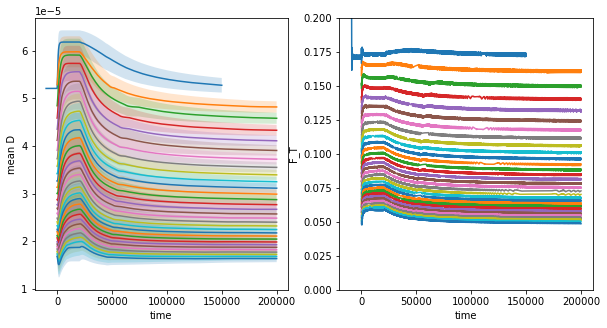

In [138]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.set_xlabel('time')
ax1.set_ylabel('mean D')
ax2.set_xlabel('time')
ax2.set_ylabel('F_T')
mean_D2 = []
speeds2, f_tips2, s_tips2 = np.array([]),np.array([]), np.array([])
D_flin2 = np.array([])
est2 = np.array([])
for w in waves2:
    speeds2 = np.append(speeds2, np.mean(w.traj.speed(5)[-50:]))
    f_tips2 = np.append(f_tips2, np.mean(w.traj.f_tip[-50:]))
    s_tips2 = np.append(s_tips2, np.mean(w.traj.s_tip[-50:]))
    mean_D2.append(w.traj.mean_D[-1])
    ax1.plot(w.traj.times - w.p.t_burn, w.traj.mean_D)
    std = w.traj.std_D
    ax1.fill_between(w.traj.times - w.p.t_burn, w.traj.mean_D-std, w.traj.mean_D+std, alpha=0.2)
    ax2.plot(w.traj.times - w.p.t_burn, w.traj.f_tip)
    ax2.set_ylim(0,0.2)
    
    a, g, l = w.p.alpha, w.p.gamma, w.p.lambda_tilde
    v, f, s = speeds2[-1], f_tips2[-1], s_tips2[-1]
    est2 = np.append(est2, brentq(estf, 1e-5, 1.3e-4))
    
    if w.p.r0 > r0_lin_start:
        D_flin2 = np.append(D_flin2, D_f_lin(w.p, 1e-5, 1.3e-4))

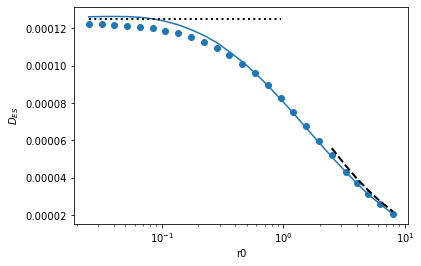

In [139]:
large_indexes = [3, 6, 10, 15, 22]
r0s = np.append(r0_list, r0_list2[large_indexes])
D_list = np.append(mean_D, np.array(mean_D2)[large_indexes])
est_list = np.append(est, np.array(est2)[large_indexes])
D_flin_list = np.append(D_flin, D_flin2[large_indexes])
D_FKPP = D_FKPP_f(waves[0].p)
speed_list = np.append(speeds, np.array(speeds2)[large_indexes])
f_tip_list = np.append(f_tips, np.array(f_tips2)[large_indexes])
s_tip_list = np.append(s_tips, np.array(s_tips2)[large_indexes])

plt.xscale('log')
plt.xlabel('r0')
plt.ylabel(r'$D_{ES}$')
plt.scatter(r0s, D_list)
plt.plot(r0s, est_list)

plt.plot(r0s[r0s > r0_lin_start], D_flin_list, c='k', ls='--', lw=2)

r0_FKPP_end = 1
plt.plot(r0s[r0s < r0_FKPP_end], np.ones(len(r0s[r0s < r0_FKPP_end]))*D_FKPP, c='k', ls=':', lw=2)

#plt.savefig('plots/es_mut_rate.svg', dpi=200)

## Exporing the points

In [140]:
f = open('data/ES_mut_rate_Dx=%g.tsv'%Delta_x, 'w')

header = '#r0\tD_ES\tD_ES_tip\tF_T\ts_T\tD_ES_FKPP\tD_ES_linfit\n'
f.write(header)

i_linfit_start = np.sum(r0s < r0_lin_start)
for i in range(len(r0s)):
    f.write(str(r0s[i]) + '\t')
    f.write(str(D_list[i]) + '\t')
    f.write(str(est_list[i]) + '\t')
    f.write(str(f_tip_list[i]) + '\t')
    f.write(str(s_tip_list[i]) + '\t')
    f.write(str(D_FKPP) + '\t')
    
    if r0s[i] >= r0_lin_start:
        f.write(str(D_flin_list[i - i_linfit_start]) + '\t')
    else:
        f.write('\t')
        
    f.write('\n')
    
f.close()

In [142]:
f = open('data/ES_mut_rate_Dx=%g_pars.tsv'%Delta_x, 'w')

header = '#parameter\tvalue\n'
f.write(header)

f.write('lambda\t' + str(waves[0].p.lambda_tilde) + '\n')
f.write('beta\t' + str(waves[0].p.beta) + '\n')
f.write('alpha\t' + str(waves[0].p.alpha) + '\n')
f.write('gamma\t' + str(waves[0].p.gamma) + '\n')
f.write('Nh\t' + str(assays[0].p.Nh) + '\n')
f.write('M\t' + str(assays[0].p.M) + '\n')
f.write('cutoff\t' + str(assays[0].p.cutoff) + '\n')

f.close()